# Biomass-Volume Regressions Analysis
This notebook provides some analysis of the structural characteristic-volume regressions and their accuracy.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import random
# import minmax scaler
from sklearn.preprocessing import MinMaxScaler
# Set random seed for reproducibility
random.seed(42)
from statsmodels.stats.diagnostic import het_white
import statsmodels.api as sm
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.colors import SymLogNorm
from matplotlib.ticker import FuncFormatter

In [2]:
# Import dfs
bdf = pd.read_csv('biomass_scrape_c3.csv')
vdf = pd.read_csv('volume_directory.csv')


In [ ]:
# Convert bdf to useful format
bdf.columns = bdf.columns.str.lower()
bdf.columns = bdf.columns.str.replace(' ', '_')
bdf.rename(columns={'aboveground_biomass':'aboveground_veg_biomass',
                    'stem_no':'shoot_no'}, inplace=True)
bdf['aboveground_total_biomass'] = bdf['aboveground_veg_biomass'] + bdf['flower_biomass'] + bdf['total_fruit_biomass']
print(bdf.columns)
bdf.drop(columns=['sampling_date', 'leaves_per_stem', 'sla', 
                  'ripe_fruit_no', 'ripe_fruit_biomass', 'species'], inplace=True)
print(bdf.columns)

In [5]:
# combine bdf and vdf by sample_id
df = pd.merge(bdf, vdf, on='sample_id', how='inner')
print(df.columns)
print(len(df))
print(df.head())

Index(['sample_id', 'plant_id', 'cultivar', 'sampling_age', 'leaf_no',
       'shoot_no', 'flower_no', 'total_fruit_no', 'leaf_biomass',
       'shoot_biomass', 'flower_biomass', 'total_fruit_biomass',
       'aboveground_veg_biomass', 'true_ground_area', 'l#pa',
       'unripe_fruit_no', 'unripe_fruit_biomass', 'aboveground_total_biomass',
       'plot_id', 'trial_dir', 'date_dir', 'species', 'width', 'depth',
       'height', 'voxel_vol_02', 'voxel_vol_01', 'voxel_vol_005',
       'voxel_vol_002', 'voxel_vol_001', 'convh_vol', 'ground_area'],
      dtype='object')
24
              sample_id                         plant_id  cultivar  \
0  ta_Big_Beef_Day_Zero  Transplant-Aged Big Beef Tomato  Big Beef   
1      gp_21_07_07_2023                               21  Big Beef   
2      gp_09_06_24_2023                               09  Big Beef   
3      gp_07_08_02_2023                               07  Big Beef   
4      gp_05_09_01_2023                               05  Big Beef   

   

In [6]:
# Drop unimportant columns
drop_cols = ['flower_no', 'total_fruit_no', 'flower_biomass', 'total_fruit_biomass',
             'true_ground_area', 'l#pa', 'unripe_fruit_no', 'unripe_fruit_biomass',
             'aboveground_total_biomass', 'trial_dir', 'date_dir', 'width', 'depth',
             'height', 'ground_area']
df.drop(columns=drop_cols, inplace=True)
print(df.columns)

Index(['sample_id', 'plant_id', 'cultivar', 'sampling_age', 'leaf_no',
       'shoot_no', 'leaf_biomass', 'shoot_biomass', 'aboveground_veg_biomass',
       'plot_id', 'species', 'voxel_vol_02', 'voxel_vol_01', 'voxel_vol_005',
       'voxel_vol_002', 'voxel_vol_001', 'convh_vol'],
      dtype='object')


In [7]:
# Drop problem rows
problem_samples = ['ta_Big_Beef_Day_Zero', 'ta_German_Johnson_Day_Zero',
                   'ta_Red_Deuce_Day_Zero', 'ta_Mambo_Day_Zero', 'gp_12_06_24_2023']
df = df[~df['sample_id'].isin(problem_samples)]

In [8]:
print(len(df))

19


In [9]:
# Subset df into species dfs
tdf = df[df['species'] == 'tomato']
wdf = df[df['species'] == 'watermelon']

In [10]:
# Create regression equations
def linear(x, a):
    return a*x

def exponential(x, a, b):
    return a*np.exp(-b*x)

def power(x, a, b):
    return a*x**b

def log(x, a, b):
    return a*np.log(b*x + 1)

def poly2deg(x, a, b):
    return a*x**2 + b*x

In [11]:
# Import regression df
rdf = pd.read_csv('Biomass_and_Volume_Regressions/best_regressions_cx3_subset_2.csv')
# Reset index
rdf.reset_index(drop=True, inplace=True)
# convert coef_a to float by dropping commas
print(rdf.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   subset         10 non-null     object 
 1   parameter      10 non-null     object 
 2   volume_method  10 non-null     object 
 3   coef_a         10 non-null     float64
 4   coef_b         1 non-null      float64
 5   r2             10 non-null     float64
 6   rmse           10 non-null     float64
 7   rrmse          10 non-null     float64
 8   equation       10 non-null     object 
dtypes: float64(5), object(4)
memory usage: 848.0+ bytes
None


In [12]:
# create a dataframe that is tdf for aboveground_veg_biomass and convh_vol
tabdf = tdf[['sample_id', 'sampling_age', 'aboveground_veg_biomass', 'voxel_vol_02', 'voxel_vol_01', 'voxel_vol_005',
       'voxel_vol_002', 'voxel_vol_001', 'convh_vol']].copy()
# create a dframe that is tdf for leaf biomass and convh_vol
tlbdf	= tdf[['sample_id', 'sampling_age', 'leaf_biomass', 'voxel_vol_02', 'voxel_vol_01', 'voxel_vol_005',
       'voxel_vol_002', 'voxel_vol_001', 'convh_vol']].copy()
# create a dframe that is tdf for leaf no and convh_vol
tln_df = tdf[['sample_id', 'sampling_age', 'leaf_no', 'voxel_vol_02', 'voxel_vol_01', 'voxel_vol_005',
       'voxel_vol_002', 'voxel_vol_001', 'convh_vol']].copy()
# create a dframe that is tdf for shoot biomass	and convh_vol
tsbdf = tdf[['sample_id', 'sampling_age', 'shoot_biomass', 'voxel_vol_02', 'voxel_vol_01', 'voxel_vol_005',
       'voxel_vol_002', 'voxel_vol_001', 'convh_vol']].copy()
# create a dframe that is tdf for shoot no and convh_vol
tsndf = tdf[['sample_id', 'sampling_age', 'shoot_no', 'voxel_vol_02', 'voxel_vol_01', 'voxel_vol_005',
       'voxel_vol_002', 'voxel_vol_001', 'convh_vol']].copy()

# create a dframe that is wdf for aboveground_veg_biomass and voxel_vol_02
wabdf = wdf[['sample_id', 'sampling_age', 'aboveground_veg_biomass', 'voxel_vol_02', 'voxel_vol_01', 'voxel_vol_005',
       'voxel_vol_002', 'voxel_vol_001', 'convh_vol']].copy()
# create a dframe that is wdf for leaf biomass and voxel_vol_02
wlbdf = wdf[['sample_id', 'sampling_age', 'leaf_biomass', 'voxel_vol_02', 'voxel_vol_01', 'voxel_vol_005',
       'voxel_vol_002', 'voxel_vol_001', 'convh_vol']].copy()
# create a dframe that is wdf for leaf no and convh_vol
wln_df = wdf[['sample_id', 'sampling_age', 'leaf_no', 'voxel_vol_02', 'voxel_vol_01', 'voxel_vol_005',
       'voxel_vol_002', 'voxel_vol_001', 'convh_vol']].copy()
# create a dframe that is wdf for shoot biomass and voxel_vol_02
wsbdf = wdf[['sample_id', 'sampling_age', 'shoot_biomass', 'voxel_vol_02', 'voxel_vol_01', 'voxel_vol_005',
       'voxel_vol_002', 'voxel_vol_001', 'convh_vol']].copy()
# create a dframe that is wdf for shoot no and voxel_vol_005
wsndf = wdf[['sample_id', 'sampling_age', 'shoot_no', 'voxel_vol_02', 'voxel_vol_01', 'voxel_vol_005',
       'voxel_vol_002', 'voxel_vol_001', 'convh_vol']].copy()

In [13]:
# define a function to calculate the regression
def calculate_regression(df, reg_type, parameter, volume, a, b):
	if reg_type == 'linear':
		df['predicted'] = linear(df[volume], a)
	elif reg_type == 'exponential':
			df['predicted'] = exponential(df[volume], a, b)
	elif reg_type == 'power':
			df['predicted'] = power(df[volume], a, b)
	elif reg_type == 'log':
			df['predicted'] = log(df[volume], a, b)
	elif reg_type == 'poly2deg':
			df['predicted'] = poly2deg(df[volume], a, b)
	else:
		raise ValueError("Unknown regression type")
	# Calculate the residuals
	df['error'] = df[parameter] - df['predicted']
	# Calculate the absolute error
	df['abs_error'] = np.abs(df['error'])
	# Calculate the percentage error
	df['perc_error'] = (df['abs_error'] / df[parameter]) * 100
	print('calculations complete')
	return df

In [14]:
# Loop through the regression df and apply the regression equations to the tdf and wdf dataframes

for index, row in rdf.iterrows():
	# Get the regression type
	reg_type = row['equation']
	
	# print index and regression type
	print(f"Processing index {index} with regression type: {reg_type}")
				
	# Get the species
	species = row['subset']
	print(f"Species: {species}")
				
	# Get the regression parameters
	a = row['coef_a']
	b = row['coef_b']
				
	parameter = row['parameter']
	# print(f"Parameter: {parameter}")
	print(f"Processing parameter: {parameter}")

	volume	= row['volume_method']
	# print volume
	print(f"Volume method: {volume}")
	# Select the appropriate dataframe based on species and parameter
	if species == 'tomato':
		if parameter == 'aboveground_veg_biomass':
			df = tabdf
			print("Using tomato aboveground veg biomass dataframe")
		elif parameter == 'leaf_biomass':
			df = tlbdf
			print("Using tomato leaf biomass dataframe")
		elif parameter == 'leaf_no':
			df = tln_df
			print("Using tomato leaf no dataframe")
		elif parameter == 'shoot_biomass':
			df = tsbdf
			print("Using tomato shoot biomass dataframe")
		elif parameter == 'shoot_no':
			df = tsndf
			print("Using tomato shoot no dataframe")
	else:
		if parameter == 'aboveground_veg_biomass':
			df = wabdf
			print("Using watermelon aboveground veg biomass dataframe")
		elif parameter == 'leaf_biomass':
			df = wlbdf
			print("Using watermelon leaf biomass dataframe")
		elif parameter == 'leaf_no':
			df = wln_df
			print("Using watermelon leaf no dataframe")
		elif parameter == 'shoot_biomass':
			df = wsbdf
			print("Using watermelon shoot biomass dataframe")
		elif parameter == 'shoot_no':
			df = wsndf
			print("Using watermelon shoot no dataframe")
	# Apply the regression equation
	df = calculate_regression(df, reg_type, parameter, volume, a, b)


Processing index 0 with regression type: linear
Species: tomato
Processing parameter: aboveground_veg_biomass
Volume method: convh_vol
Using tomato aboveground veg biomass dataframe
calculations complete
Processing index 1 with regression type: linear
Species: tomato
Processing parameter: leaf_biomass
Volume method: convh_vol
Using tomato leaf biomass dataframe
calculations complete
Processing index 2 with regression type: linear
Species: tomato
Processing parameter: leaf_no
Volume method: convh_vol
Using tomato leaf no dataframe
calculations complete
Processing index 3 with regression type: linear
Species: tomato
Processing parameter: shoot_biomass
Volume method: convh_vol
Using tomato shoot biomass dataframe
calculations complete
Processing index 4 with regression type: linear
Species: tomato
Processing parameter: shoot_no
Volume method: convh_vol
Using tomato shoot no dataframe
calculations complete
Processing index 5 with regression type: linear
Species: watermelon
Processing param

In [15]:
# calculate rmse for tomato aboveground veg biomass
rmse_tomato_aboveground = np.sqrt(np.mean(tabdf['error']**2))
print(f"RMSE for Tomato Aboveground Veg Biomass: {rmse_tomato_aboveground}")
# calculate rrmse for tomato aboveground veg biomass
rrmse_tomato_aboveground = rmse_tomato_aboveground / np.mean(tabdf['aboveground_veg_biomass'])
print(f"RRMSE for Tomato Aboveground Veg Biomass: {rrmse_tomato_aboveground}")
# calculate rmse for tomato leaf biomass
rmse_tomato_leaf = np.sqrt(np.mean(tlbdf['error']**2))
print(f"RMSE for Tomato Leaf Biomass: {rmse_tomato_leaf}")
# calculate rrmse for tomato leaf biomass
rrmse_tomato_leaf = rmse_tomato_leaf / np.mean(tlbdf['leaf_biomass'])
print(f"RRMSE for Tomato Leaf Biomass: {rrmse_tomato_leaf}")
# calculate rmse for tomato leaf no
rmse_tomato_leaf_no = np.sqrt(np.mean(tln_df['error']**2))
print(f"RMSE for Tomato Leaf Number: {rmse_tomato_leaf_no}")
# calculate rrmse for tomato leaf no
rrmse_tomato_leaf_no = rmse_tomato_leaf_no / np.mean(tln_df['leaf_no'])
print(f"RRMSE for Tomato Leaf Number: {rrmse_tomato_leaf_no}")

RMSE for Tomato Aboveground Veg Biomass: 52.58753906704871
RRMSE for Tomato Aboveground Veg Biomass: 0.25552627196519845
RMSE for Tomato Leaf Biomass: 16.53158808291789
RRMSE for Tomato Leaf Biomass: 0.19047802837789937
RMSE for Tomato Leaf Number: 108.33672476498084
RRMSE for Tomato Leaf Number: 0.22506212887909147


In [16]:
# Test for heteroscedasticity using White's test
def test_heteroscedasticity(df, parameter, volume):
	y = df[parameter]
	residuals = df['error']
	X_with_const = sm.add_constant(df[[volume]])
	print(f"Testing heteroscedasticity for {parameter} with volume {volume}")
	# Perform White's test
	test_statistic, p_value, _, _ = het_white(df['error'], X_with_const)
	print(f"White's test statistic: {test_statistic}, p-value: {p_value}")
	if p_value < 0.05:
		print("Heteroscedasticity detected")
	else:
		print("No heteroscedasticity detected")

# Test heteroscedasticity for tomato aboveground veg biomass
test_heteroscedasticity(tabdf, 'aboveground_veg_biomass', 'convh_vol')
# Test heteroscedasticity for tomato leaf biomass
test_heteroscedasticity(tlbdf, 'leaf_biomass', 'convh_vol')
# Test heteroscedasticity for tomato leaf no
test_heteroscedasticity(tln_df, 'leaf_no', 'convh_vol')
# Test for heteroscedasticity for tomato shoot biomass
test_heteroscedasticity(tsbdf, 'shoot_biomass', 'convh_vol')
# Test for heteroscedasticity for tomato shoot no
test_heteroscedasticity(tsndf, 'shoot_no', 'convh_vol')
# Test heteroscedasticity for watermelon aboveground veg biomass
test_heteroscedasticity(wabdf, 'aboveground_veg_biomass', 'voxel_vol_02')
# Test heteroscedasticity for watermelon leaf biomass
test_heteroscedasticity(wlbdf, 'leaf_biomass', 'voxel_vol_02')
# Test heteroscedasticity for watermelon leaf no
test_heteroscedasticity(wln_df, 'leaf_no', 'convh_vol')
# Test for heteroscedasticity for watermelon shoot biomass
test_heteroscedasticity(wsbdf, 'shoot_biomass', 'voxel_vol_02')
# Test for heteroscedasticity for watermelon shoot no
test_heteroscedasticity(wsndf, 'shoot_no', 'voxel_vol_005')

Testing heteroscedasticity for aboveground_veg_biomass with volume convh_vol
White's test statistic: 7.082540711338753, p-value: 0.028976493238645262
Heteroscedasticity detected
Testing heteroscedasticity for leaf_biomass with volume convh_vol
White's test statistic: 5.342250132492472, p-value: 0.06917435578057672
No heteroscedasticity detected
Testing heteroscedasticity for leaf_no with volume convh_vol
White's test statistic: 4.897323488956807, p-value: 0.08640914667525675
No heteroscedasticity detected
Testing heteroscedasticity for shoot_biomass with volume convh_vol
White's test statistic: 6.5486592387081, p-value: 0.03784222942608963
Heteroscedasticity detected
Testing heteroscedasticity for shoot_no with volume convh_vol
White's test statistic: 2.310270580669581, p-value: 0.31501491554696137
No heteroscedasticity detected
Testing heteroscedasticity for aboveground_veg_biomass with volume voxel_vol_02
White's test statistic: 3.067942258570734, p-value: 0.21567748129780628
No hete

In [17]:
# Give each df a column for relative residuals
tabdf['relative_residuals'] = 100 * (tabdf['aboveground_veg_biomass'] - tabdf['predicted']) / tabdf['aboveground_veg_biomass']
tlbdf['relative_residuals'] = 100 * (tlbdf['leaf_biomass'] - tlbdf['predicted']) / tlbdf['leaf_biomass']
tln_df['relative_residuals'] = 100 * (tln_df['leaf_no'] - tln_df['predicted']) / tln_df['leaf_no']
tsbdf['relative_residuals'] = 100 * (tsbdf['shoot_biomass'] - tsbdf['predicted']) / tsbdf['shoot_biomass']
tsndf['relative_residuals'] = 100 * (tsndf['shoot_no'] - tsndf['predicted']) / tsndf['shoot_no']
wabdf['relative_residuals'] = 100 * (wabdf['aboveground_veg_biomass'] - wabdf['predicted']) / wabdf['aboveground_veg_biomass']
wlbdf['relative_residuals'] = 100 * (wlbdf['leaf_biomass'] - wlbdf['predicted']) / wlbdf['leaf_biomass']
wln_df['relative_residuals'] = 100 * (wln_df['leaf_no'] - wln_df['predicted']) / wln_df['leaf_no']
wsbdf['relative_residuals'] = 100 * (wsbdf['shoot_biomass'] - wsbdf['predicted']) / wsbdf['shoot_biomass']
wsndf['relative_residuals'] = 100 * (wsndf['shoot_no'] - wsndf['predicted']) / wsndf['shoot_no']

In [18]:
# Add a suffix to the following column names in each dataframe for each parameter
column_names = ['predicted', 'error', 'abs_error', 'perc_error', 'relative_residuals']
suffixes = ['aboveground_veg_biomass', 'leaf_biomass', 'leaf_no', 'shoot_biomass', 'shoot_no']
# add to tabdf
for col in column_names:
	tabdf.rename(columns={col: f"{col}_{suffixes[0]}"}, inplace=True)
# add to tlbdf
for col in column_names:
	tlbdf.rename(columns={col: f"{col}_{suffixes[1]}"}, inplace=True)
# add to tln_df
for col in column_names:
	tln_df.rename(columns={col: f"{col}_{suffixes[2]}"}, inplace=True)
# add to tsbdf
for col in column_names:
	tsbdf.rename(columns={col: f"{col}_{suffixes[3]}"}, inplace=True)
# add to tsndf
for col in column_names:
	tsndf.rename(columns={col: f"{col}_{suffixes[4]}"}, inplace=True)
# add to wabdf
for col in column_names:
	wabdf.rename(columns={col: f"{col}_{suffixes[0]}"}, inplace=True)
# add to wlbdf
for col in column_names:
	wlbdf.rename(columns={col: f"{col}_{suffixes[1]}"}, inplace=True)
# add to wln_df
for col in column_names:
	wln_df.rename(columns={col: f"{col}_{suffixes[2]}"}, inplace=True)
# add to wsbdf
for col in column_names:
	wsbdf.rename(columns={col: f"{col}_{suffixes[3]}"}, inplace=True)
# add to wsndf
for col in column_names:
	wsndf.rename(columns={col: f"{col}_{suffixes[4]}"}, inplace=True)


In [19]:
# Add a column to each dataframe that is its respective parameter name
tabdf['parameter'] = 'aboveground_veg_biomass'
tlbdf['parameter'] = 'leaf_biomass'
tln_df['parameter'] = 'leaf_no'
tsbdf['parameter'] = 'shoot_biomass'
tsndf['parameter'] = 'shoot_no'
wabdf['parameter'] = 'aboveground_veg_biomass'
wlbdf['parameter'] = 'leaf_biomass'
wln_df['parameter'] = 'leaf_no'
wsbdf['parameter'] = 'shoot_biomass'
wsndf['parameter'] = 'shoot_no'

In [20]:
# add a column to each dataframe that is its respective species
tabdf['species'] = 'tomato'
tlbdf['species'] = 'tomato'
tln_df['species'] = 'tomato'
tsbdf['species'] = 'tomato'
tsndf['species'] = 'tomato'
wabdf['species'] = 'watermelon'
wlbdf['species'] = 'watermelon'
wln_df['species'] = 'watermelon'
wsbdf['species'] = 'watermelon'
wsndf['species'] = 'watermelon'


In [21]:
# Concat all dataframes into a single dataframe
all_df = pd.concat([tabdf, tlbdf, tln_df, tsbdf, tsndf, wabdf, wlbdf, wln_df, wsbdf, wsndf], ignore_index=True)
# Save the all_df to a csv file
all_df.to_csv('subset_regression_results_raw.csv', index=False)

In [22]:
# import processed csv file
processed_df = pd.read_csv('subset_regression_results_processed.csv')
print(processed_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sample_id           95 non-null     object 
 1   sampling_age        95 non-null     int64  
 2   parameter           95 non-null     object 
 3   species             95 non-null     object 
 4   voxel_vol_02        95 non-null     float64
 5   voxel_vol_01        95 non-null     float64
 6   voxel_vol_005       95 non-null     float64
 7   voxel_vol_002       95 non-null     float64
 8   voxel_vol_001       95 non-null     float64
 9   convh_vol           95 non-null     float64
 10  true_value          95 non-null     float64
 11  predicted_value     95 non-null     float64
 12  error_value         95 non-null     float64
 13  abs_error           95 non-null     float64
 14  perc_error          95 non-null     float64
 15  relative_residuals  95 non-null     float64
dtypes: float64

In [23]:
# make a df for each species and parameter
tab = processed_df.loc[(processed_df['species'] == 'tomato') & (processed_df['parameter'] == 'aboveground_veg_biomass')]
tlb = processed_df.loc[(processed_df['species'] == 'tomato') & (processed_df['parameter'] == 'leaf_biomass')]
tln = processed_df.loc[(processed_df['species'] == 'tomato') & (processed_df['parameter'] == 'leaf_no')]
tsb = processed_df.loc[(processed_df['species'] == 'tomato') & (processed_df['parameter'] == 'shoot_biomass')]
tsn = processed_df.loc[(processed_df['species'] == 'tomato') & (processed_df['parameter'] == 'shoot_no')]
wab = processed_df.loc[(processed_df['species'] == 'watermelon') & (processed_df['parameter'] == 'aboveground_veg_biomass')]
wlb = processed_df.loc[(processed_df['species'] == 'watermelon') & (processed_df['parameter'] == 'leaf_biomass')]
wln = processed_df.loc[(processed_df['species'] == 'watermelon') & (processed_df['parameter'] == 'leaf_no')]
wsb = processed_df.loc[(processed_df['species'] == 'watermelon') & (processed_df['parameter'] == 'shoot_biomass')]
wsn = processed_df.loc[(processed_df['species'] == 'watermelon') & (processed_df['parameter'] == 'shoot_no')]

In [24]:
print(processed_df['relative_residuals'].describe())

count     95.000000
mean     -39.127395
std       87.036696
min     -473.227954
25%      -68.584043
50%      -11.304039
75%        8.765769
max       78.985576
Name: relative_residuals, dtype: float64


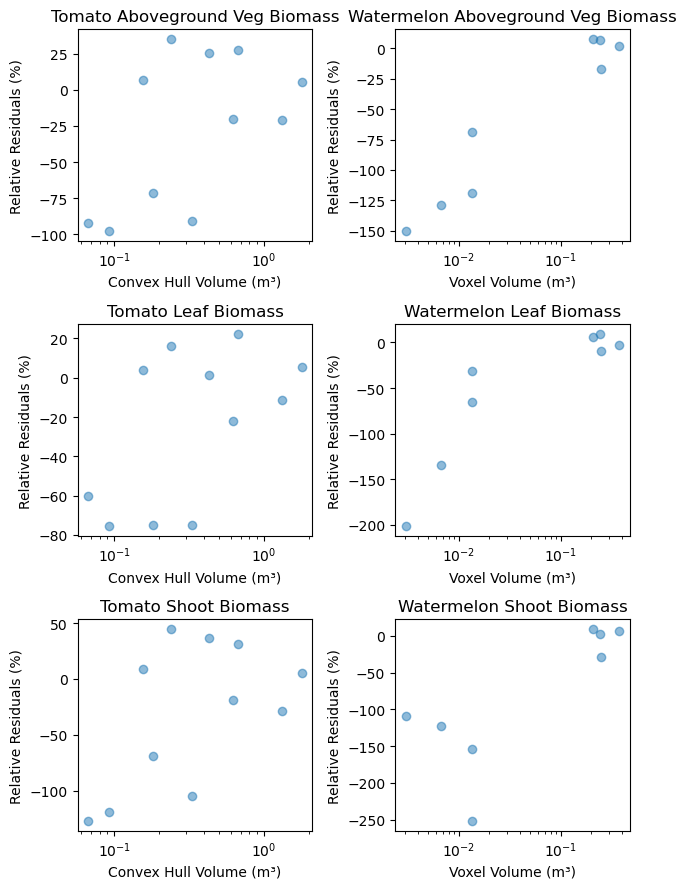

In [25]:
# make a figure for each species parameter plotting relative residuals vs volume
from matplotlib.ticker import ScalarFormatter
formatter = ScalarFormatter()
formatter.set_scientific(False)
# Set the style for the plots
fig, axs = plt.subplots(3, 2, figsize=(6.5, 9))

# Tomato Aboveground Veg Biomass
axs[0, 0].scatter(tab['convh_vol'], tab['relative_residuals'], alpha=0.5, label='Tomato Aboveground Veg Biomass')
axs[0, 0].set_title('Tomato Aboveground Veg Biomass')
axs[0, 0].set_xlabel('Convex Hull Volume (m³)')
axs[0, 0].set_ylabel('Relative Residuals (%)')
# set axis scale to log
axs[0, 0].set_xscale('log')
# Tomato Leaf Biomass

axs[1, 0].scatter(tlb['convh_vol'], tlb['relative_residuals'], alpha=0.5, label='Tomato Leaf Biomass')
axs[1, 0].set_title('Tomato Leaf Biomass')
axs[1, 0].set_xlabel('Convex Hull Volume (m³)')
axs[1, 0].set_ylabel('Relative Residuals (%)')
# set axis scale to log
axs[1, 0].set_xscale('log')
# Tomato Stem Biomass
axs[2, 0].xaxis.set_major_formatter(ScalarFormatter())
axs[2, 0].ticklabel_format(style='plain', axis='x')
axs[2, 0].scatter(tsb['convh_vol'], tsb['relative_residuals'], alpha=0.5, label='Tomato Shoot Biomass')
axs[2, 0].set_title('Tomato Shoot Biomass')
axs[2, 0].set_xlabel('Convex Hull Volume (m³)')
axs[2, 0].set_ylabel('Relative Residuals (%)')
# set axis scale to log
axs[2, 0].set_xscale('log')
# Watermelon Aboveground Veg Biomass

axs[0, 1].scatter(wab['voxel_vol_02'], wab['relative_residuals'], alpha=0.5, label='Watermelon Aboveground Veg Biomass')
axs[0, 1].set_title('Watermelon Aboveground Veg Biomass')
axs[0, 1].set_xlabel('Voxel Volume (m³)')
axs[0, 1].set_ylabel('Relative Residuals (%)')
# set axis scale to log
axs[0, 1].set_xscale('log')
# Watermelon Leaf Biomass

axs[1, 1].scatter(wlb['voxel_vol_02'], wlb['relative_residuals'], alpha=0.5, label='Watermelon Leaf Biomass')
axs[1, 1].set_title('Watermelon Leaf Biomass')
axs[1, 1].set_xlabel('Voxel Volume (m³)')
axs[1, 1].set_ylabel('Relative Residuals (%)')
# set axis scale to log
axs[1, 1].set_xscale('log')
# Watermelon Stem Biomass

axs[2, 1].scatter(wsb['voxel_vol_02'], wsb['relative_residuals'], alpha=0.5, label='Watermelon Shoot Biomass')
axs[2, 1].set_title('Watermelon Shoot Biomass')
axs[2, 1].set_xlabel('Voxel Volume (m³)')
axs[2, 1].set_ylabel('Relative Residuals (%)')
# set axis scale to log
axs[2, 1].set_xscale('log')
# Adjust layout
plt.tight_layout()

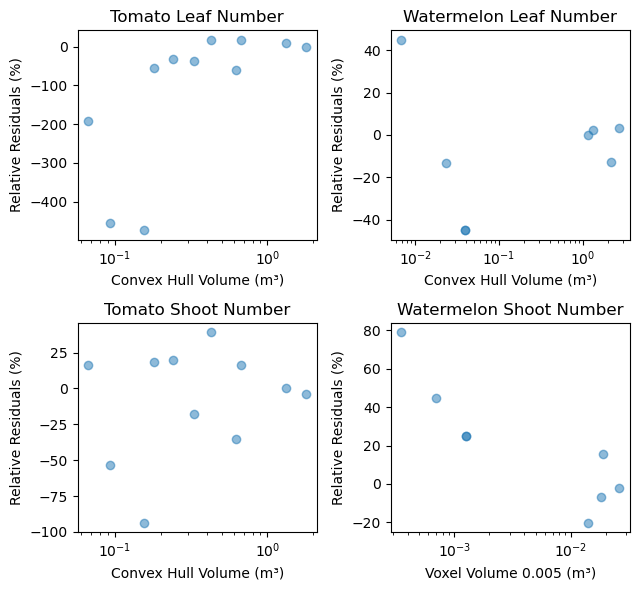

In [26]:
# make a figure for each species number parameter plotting relative residuals vs volume
# Tomato Leaf Number
fig, axs = plt.subplots(2, 2, figsize=(6.5, 6))
axs[0, 0].scatter(tln['convh_vol'], tln['relative_residuals'], alpha=0.5, label='Tomato Leaf Number')
axs[0, 0].set_title('Tomato Leaf Number')
axs[0, 0].set_xlabel('Convex Hull Volume (m³)')
axs[0, 0].set_ylabel('Relative Residuals (%)')
# set axis scale to log
axs[0, 0].set_xscale('log')
# Tomato Shoot Number
axs[1, 0].scatter(tsn['convh_vol'], tsn['relative_residuals'], alpha=0.5, label='Tomato Shoot Number')
axs[1, 0].set_title('Tomato Shoot Number')
axs[1, 0].set_xlabel('Convex Hull Volume (m³)')
axs[1, 0].set_ylabel('Relative Residuals (%)')
# set axis scale to log
axs[1, 0].set_xscale('log')
# Watermelon Leaf Number
axs[0, 1].scatter(wln['convh_vol'], wln['relative_residuals'], alpha=0.5, label='Watermelon Leaf Number')
axs[0, 1].set_title('Watermelon Leaf Number')
axs[0, 1].set_xlabel('Convex Hull Volume (m³)')
axs[0, 1].set_ylabel('Relative Residuals (%)')
# set axis scale to log
axs[0, 1].set_xscale('log')
# Watermelon Shoot Number
axs[1, 1].scatter(wsn['voxel_vol_005'], wsn['relative_residuals'], alpha=0.5, label='Watermelon Shoot Number')
axs[1, 1].set_title('Watermelon Shoot Number')
axs[1, 1].set_xlabel('Voxel Volume 0.005 (m³)')
axs[1, 1].set_ylabel('Relative Residuals (%)')
# set axis scale to log
axs[1, 1].set_xscale('log')
# Adjust layout
plt.tight_layout()

C:\Users\Steven\AppData\Local\Temp\ipykernel_19296\2172541749.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


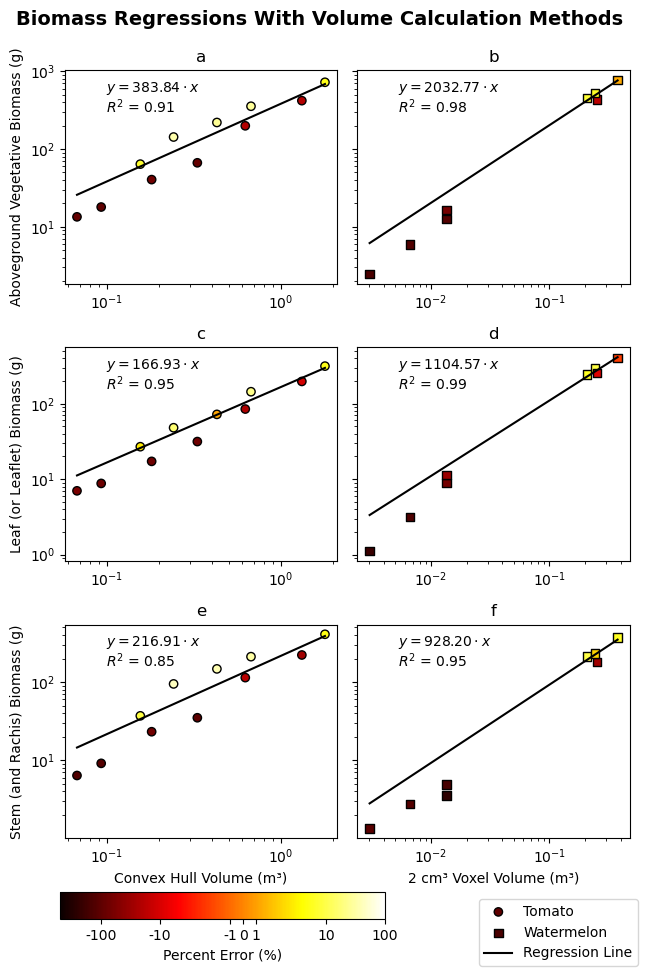

In [39]:
# Plot aboveground veg biomass on two axes, shared y axis
fig, ax = plt.subplots(3, 2, sharey='row', figsize=(6.5, 9))
fig.suptitle('Biomass Regressions With Volume Calculation Methods', fontsize=14, fontweight='bold', y=0.99)

vmin = -500
vmax = 100
cmap = 'hot'
norm = SymLogNorm(linthresh=5, linscale=1, vmin=vmin, vmax=vmax, base=10)

ax[0, 0].set_title('a')
ax[0, 0].scatter(tab['convh_vol'], tab['true_value'], label='Tomato', marker='o',
                  c=tab['relative_residuals'], cmap='hot', edgecolors='black',
                  norm=norm)
tvx = np.linspace(tab['convh_vol'].min(), tab['convh_vol'].max(), 100)
ax[0, 0].plot(tvx, linear(tvx, *rdf[(rdf['subset'] == 'tomato') & (rdf['parameter'] == 'aboveground_veg_biomass') & 
                                    (rdf['volume_method'] == 'convh_vol')]['coef_a']), 
                                    label='Regression Line', c='black', linestyle='solid')
ax[0, 0].set_ylabel('Aboveground Vegetative Biomass (g)')
eq = r'$y = {a:.2f} \cdot x$'.format(a=383.84)
# Add r2 value to left of the plot
r2 = '$R^2$ = {r:.2f}'.format(r=0.908)
ax[0, 0].text(0.15, 0.9, eq, ha='left', va='baseline', transform=ax[0, 0].transAxes)
ax[0, 0].text(0.15, 0.8, r2, ha='left', va='baseline', transform=ax[0, 0].transAxes)
# set axis scale to log
ax[0, 0].set_xscale('log')
ax[0, 0].set_yscale('log')

ax[0, 1].set_title('b')
ax[0, 1].scatter(wab['voxel_vol_02'], wab['true_value'], label='Watermelon', marker='s',
				  c=wab['relative_residuals'], cmap='hot', edgecolors='black',
                  norm=norm)
tvx = np.linspace(wab['voxel_vol_02'].min(), wab['voxel_vol_02'].max(), 100)
ax[0, 1].plot(tvx, linear(tvx, *rdf[(rdf['subset'] == 'watermelon') & (rdf['parameter'] == 'aboveground_veg_biomass') & 
									(rdf['volume_method'] == 'voxel_vol_02')]['coef_a']), 
									label='Regression Line', c='black', linestyle='solid')

eq = r'$y = {a:.2f} \cdot x$'.format(a=2032.77)
# Add r2 value to right of the plot
r2 = '$R^2$ = {r:.2f}'.format(r=0.980)
ax[0, 1].text(0.15, 0.9, eq, ha='left', va='baseline', transform=ax[0, 1].transAxes)
ax[0, 1].text(0.15, 0.8, r2, ha='left', va='baseline', transform=ax[0, 1].transAxes)
# set axis scale to log
ax[0, 1].set_xscale('log')
ax[0, 1].set_yscale('log')

# Plot leaf biomass on two axes, shared y axis
ax[1, 0].set_title('c')
ax[1, 0].scatter(tlb['convh_vol'], tlb['true_value'], label='Tomato', marker='o',
				  c=tlb['relative_residuals'], cmap='hot', edgecolors='black',
                  norm=norm)
tvx = np.linspace(tlb['convh_vol'].min(), tlb['convh_vol'].max(), 100)
ax[1, 0].plot(tvx, linear(tvx, *rdf[(rdf['subset'] == 'tomato') & (rdf['parameter'] == 'leaf_biomass') & 
									(rdf['volume_method'] == 'convh_vol')]['coef_a']), 
									label='Regression Line', c='black', linestyle='solid')
ax[1, 0].set_ylabel('Leaf (or Leaflet) Biomass (g)')
eq = r'$y = {a:.2f} \cdot x$'.format(a=166.93)
# Add r2 value to left of the plot
r2 = '$R^2$ = {r:.2f}'.format(r=0.9507)
ax[1, 0].text(0.15, 0.9, eq, ha='left', va='baseline', transform=ax[1, 0].transAxes)
ax[1, 0].text(0.15, 0.8, r2, ha='left', va='baseline', transform=ax[1, 0].transAxes)
# set axis scale to log
ax[1, 0].set_xscale('log')
ax[1, 0].set_yscale('log')

ax[1, 1].set_title('d')
ax[1, 1].scatter(wlb['voxel_vol_02'], wlb['true_value'], label='Watermelon', marker='s',
				  c=wlb['relative_residuals'], cmap='hot', edgecolors='black',
                  norm=norm)
tvx = np.linspace(wlb['voxel_vol_02'].min(), wlb['voxel_vol_02'].max(), 100)
ax[1, 1].plot(tvx, linear(tvx, *rdf[(rdf['subset'] == 'watermelon') & (rdf['parameter'] == 'leaf_biomass') & 
									(rdf['volume_method'] == 'voxel_vol_02')]['coef_a']), 
									label='Regression Line', c='black', linestyle='solid')

eq = r'$y = {a:.2f} \cdot x$'.format(a=1104.57)
# Add r2 value to right of the plot
r2 = '$R^2$ = {r:.2f}'.format(r=0.9856)
ax[1, 1].text(0.15, 0.9, eq, ha='left', va='baseline', transform=ax[1, 1].transAxes)
ax[1, 1].text(0.15, 0.8, r2, ha='left', va='baseline', transform=ax[1, 1].transAxes)
# set axis scale to log
ax[1, 1].set_xscale('log')
ax[1, 1].set_yscale('log')

# Plot shoot
# biomass on two axes, shared y axis
ax[2, 0].set_title('e')
ax[2, 0].scatter(tsb['convh_vol'], tsb['true_value'], label='Tomato', marker='o',
				  c=tsb['relative_residuals'], cmap='hot', edgecolors='black',
                  norm=norm)
tvx = np.linspace(tsb['convh_vol'].min(), tsb['convh_vol'].max(), 100)
ax[2, 0].plot(tvx, linear(tvx, *rdf[(rdf['subset'] == 'tomato') & (rdf['parameter'] == 'shoot_biomass') & 
									(rdf['volume_method'] == 'convh_vol')]['coef_a']), 
									label='Regression Line', c='black', linestyle='solid')
ax[2, 0].set_ylabel('Stem (and Rachis) Biomass (g)')
eq = r'$y = {a:.2f} \cdot x$'.format(a=216.91)
# Add r2 value to left of the plot
r2 = '$R^2$ = {r:.2f}'.format(r=0.855)
ax[2, 0].text(0.15, 0.9, eq, ha='left', va='baseline', transform=ax[2, 0].transAxes)
ax[2, 0].text(0.15, 0.8, r2, ha='left', va='baseline', transform=ax[2, 0].transAxes)
ax[2, 0].set_xlabel('Convex Hull Volume (m³)')
ax[2, 0].set_xscale('log')
ax[2, 0].set_yscale('log')

ax[2, 1].set_title('f')
ax[2, 1].scatter(wsb['voxel_vol_02'], wsb['true_value'], label='Watermelon', marker='s',
				  c=wsb['relative_residuals'], cmap='hot', edgecolors='black',
                  norm=norm)
tvx = np.linspace(wsb['voxel_vol_02'].min(), wsb['voxel_vol_02'].max(), 100)
ax[2, 1].plot(tvx, linear(tvx, *rdf[(rdf['subset'] == 'watermelon') & (rdf['parameter'] == 'shoot_biomass') & 
									(rdf['volume_method'] == 'voxel_vol_02')]['coef_a']), 
									label='Regression Line', c='black', linestyle='solid')
eq = r'$y = {a:.2f} \cdot x$'.format(a=928.20)
# Add r2 value to right of the plot
r2 = '$R^2$ = {r:.2f}'.format(r=0.95245)
ax[2, 1].text(0.15, 0.9, eq, ha='left', va='baseline', transform=ax[2, 1].transAxes)
ax[2, 1].text(0.15, 0.8, r2, ha='left', va='baseline', transform=ax[2, 1].transAxes)
ax[2, 1].set_xlabel('2 cm³ Voxel Volume (m³)')
ax[2, 1].set_xscale('log')
ax[2, 1].set_yscale('log')

sm = ScalarMappable(norm=norm, cmap=cmap)
cbar_ax = fig.add_axes([0.1, -0.02, 0.5, 0.03])  # Centered at bottom
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label("Percent Error (%)")
cbar.ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.0f}"))

# Gather unique handles and labels from all subplots
handles, labels = [], []
for row in ax:  # Loop through each row of subplots
    for ax in row:  # Loop through each subplot in the row
        h, l = ax.get_legend_handles_labels()
        for handle, label in zip(h, l):
            if label not in labels:  # Prevent duplicates
                handles.append(handle)
                labels.append(label)
# Sort with a custom order
custom_order = ['Tomato', 'Watermelon', 'Regression Line']
handles = [h for _, h in sorted(zip(labels, handles), key=lambda pair: custom_order.index(pair[0]))]
labels = sorted(labels, key=lambda x: custom_order.index(x))
# Create a figure-level legend with unique items
fig.legend(handles, labels, loc="lower right", bbox_to_anchor=(1, -0.08))


# Adjust layout
fig.tight_layout()
# Save the figure
plt.savefig('plot_figs/biomass_regressions_with_volume_calculation_methods.png', dpi=300, bbox_inches='tight')

C:\Users\Steven\AppData\Local\Temp\ipykernel_19296\410612941.py:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


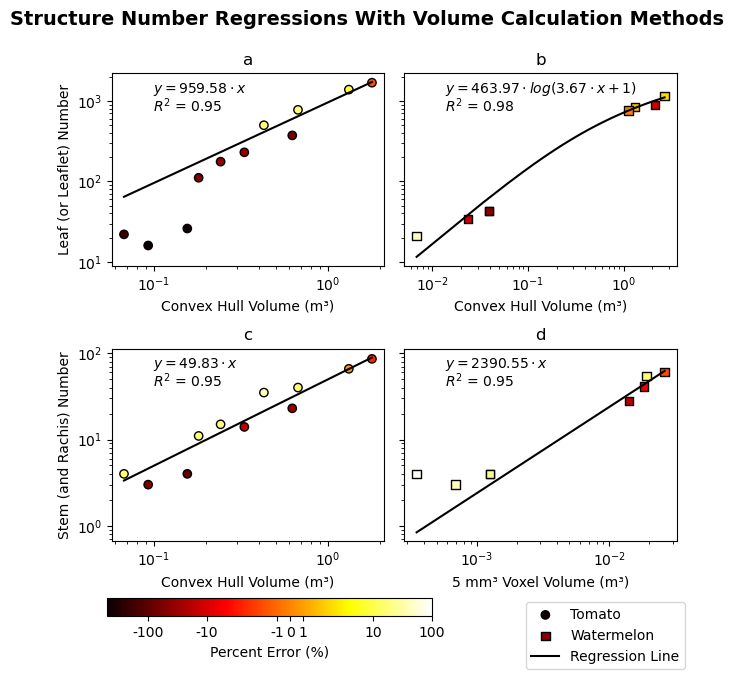

In [40]:
# Plot structure numbers on two axes, shared y axis
fig, axs = plt.subplots(2, 2, sharey='row', figsize=(6.5, 6))
fig.suptitle('Structure Number Regressions With Volume Calculation Methods', fontsize=14, fontweight='bold', y=0.99)

vmin = -500
vmax = 100
cmap = 'hot'
norm = SymLogNorm(linthresh=5, linscale=1, vmin=vmin, vmax=vmax, base=10)

# Tomato leaf num
axs[0, 0].set_title('a')
axs[0, 0].scatter(tln['convh_vol'], tln['true_value'], label='Tomato', marker='o',
				  c=tln['relative_residuals'], cmap='hot', edgecolors='black',
				  norm=norm)
tvx = np.linspace(tln['convh_vol'].min(), tln['convh_vol'].max(), 100)
axs[0, 0].plot(tvx, linear(tvx, *rdf[(rdf['subset'] == 'tomato') & (rdf['parameter'] == 'leaf_no') & 
									(rdf['volume_method'] == 'convh_vol')]['coef_a']), 
									label='Regression Line', c='black', linestyle='solid')
eq = r'$y = {a:.2f} \cdot x$'.format(a=959.5816051)
# Add r2 value to left of the plot
r2 = '$R^2$ = {r:.2f}'.format(r=0.953204479)
axs[0, 0].text(0.15, 0.9, eq, ha='left', va='baseline', transform=axs[0, 0].transAxes)
axs[0, 0].text(0.15, 0.8, r2, ha='left', va='baseline', transform=axs[0, 0].transAxes)
axs[0, 0].set_ylabel('Leaf (or Leaflet) Number')
axs[0, 0].set_xlabel('Convex Hull Volume (m³)')
axs[0, 0].set_xscale('log')
axs[0, 0].set_yscale('log')
# Watermelon leaf num
axs[0, 1].set_title('b')
axs[0, 1].scatter(wln['convh_vol'], wln['true_value'], label='Watermelon', marker='s',
				  c=wln['relative_residuals'], cmap='hot', edgecolors='black',
				  norm=norm)
tvx = np.linspace(wln['convh_vol'].min(), wln['convh_vol'].max(), 100)
axs[0, 1].plot(tvx, log(tvx, *rdf[(rdf['subset'] == 'watermelon') & (rdf['parameter'] == 'leaf_no') & 
									(rdf['volume_method'] == 'convh_vol')]['coef_a'], 
									*rdf[(rdf['subset'] == 'watermelon') & (rdf['parameter'] == 'leaf_no') & 
									(rdf['volume_method'] == 'convh_vol')]['coef_b']),
									label='Regression Line', c='black', linestyle='solid')
eq = r'$y = {a:.2f} \cdot log({b:.2f} \cdot x + 1)$'.format(a=463.9711828, b=3.668677192)
# Add r2 value to right of the plot
r2 = '$R^2$ = {r:.2f}'.format(r=0.97517354)
axs[0, 1].text(0.15, 0.9, eq, ha='left', va='baseline', transform=axs[0, 1].transAxes)
axs[0, 1].text(0.15, 0.8, r2, ha='left', va='baseline', transform=axs[0, 1].transAxes)
axs[0, 1].set_xlabel('Convex Hull Volume (m³)')
axs[0, 1].set_xscale('log')
axs[0, 1].set_yscale('log')
# Tomato shoot num
axs[1, 0].set_title('c')
axs[1, 0].scatter(tsn['convh_vol'], tsn['true_value'], label='Tomato', marker='o',
				  c=tsn['relative_residuals'], cmap='hot', edgecolors='black',
				  norm=norm)
tvx = np.linspace(tsn['convh_vol'].min(), tsn['convh_vol'].max(), 100)
axs[1, 0].plot(tvx, linear(tvx, *rdf[(rdf['subset'] == 'tomato') & (rdf['parameter'] == 'shoot_no') & 
									(rdf['volume_method'] == 'convh_vol')]['coef_a']), 
									label='Regression Line', c='black', linestyle='solid')
eq = r'$y = {a:.2f} \cdot x$'.format(a=49.83366505)
# Add r2 value to left of the plot
r2 = '$R^2$ = {r:.2f}'.format(r=0.946517077)
axs[1, 0].text(0.15, 0.9, eq, ha='left', va='baseline', transform=axs[1, 0].transAxes)
axs[1, 0].text(0.15, 0.8, r2, ha='left', va='baseline', transform=axs[1, 0].transAxes)
axs[1, 0].set_ylabel('Stem (and Rachis) Number')
axs[1, 0].set_xlabel('Convex Hull Volume (m³)')
axs[1, 0].set_xscale('log')
axs[1, 0].set_yscale('log')
# Watermelon shoot num
axs[1, 1].set_title('d')
axs[1, 1].scatter(wsn['voxel_vol_005'], wsn['true_value'], label='Watermelon', marker='s',
				  c=wsn['relative_residuals'], cmap='hot', edgecolors='black',
				  norm=norm)
tvx = np.linspace(wsn['voxel_vol_005'].min(), wsn['voxel_vol_005'].max(), 100)
axs[1, 1].plot(tvx, linear(tvx, *rdf[(rdf['subset'] == 'watermelon') & (rdf['parameter'] == 'shoot_no') & 
									(rdf['volume_method'] == 'voxel_vol_005')]['coef_a']), 
									label='Regression Line', c='black', linestyle='solid')
eq = r'$y = {a:.2f} \cdot x$'.format(a=2390.549449)
# Add r2 value to right of the plot
r2 = '$R^2$ = {r:.2f}'.format(r=0.954679945)
axs[1, 1].text(0.15, 0.9, eq, ha='left', va='baseline', transform=axs[1, 1].transAxes)
axs[1, 1].text(0.15, 0.8, r2, ha='left', va='baseline', transform=axs[1, 1].transAxes)
axs[1, 1].set_xlabel('5 mm³ Voxel Volume (m³)')
axs[1, 1].set_xscale('log')
axs[1, 1].set_yscale('log')
# Add colorbar
sm = ScalarMappable(norm=norm, cmap=cmap)
cbar_ax = fig.add_axes([0.1, -0.02, 0.5, 0.03])  # Centered at bottom
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label("Percent Error (%)")
cbar.ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.0f}"))
# Gather unique handles and labels from all subplots
handles, labels = [], []
for row in axs:  # Loop through each row of subplots
	for ax in row:  # Loop through each subplot in the row
		h, l = ax.get_legend_handles_labels()
		for handle, label in zip(h, l):
			if label not in labels:  # Prevent duplicates
				handles.append(handle)
				labels.append(label)
# Sort with a custom order
custom_order = ['Tomato', 'Watermelon', 'Regression Line']
handles = [h for _, h in sorted(zip(labels, handles), key=lambda pair: custom_order.index(pair[0]))]
labels = sorted(labels, key=lambda x: custom_order.index(x))
# Create a figure-level legend with unique items
fig.legend(handles, labels, loc="lower right", bbox_to_anchor=(1, -0.12))
# Adjust layout
fig.tight_layout()
# Save the figure
plt.savefig('plot_figs/structure_number_regressions_with_volume_calculation_methods.png', dpi=300, bbox_inches='tight')

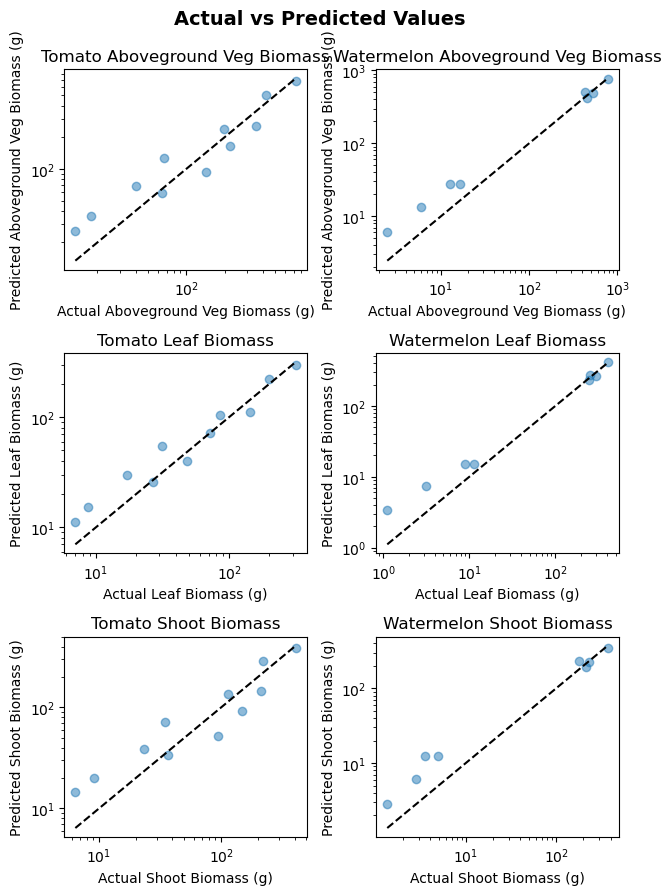

In [33]:
# Plot actual vs predicted values for each species and parameter not using seaborn
fig, axs = plt.subplots(3, 2, figsize=(6.5, 9))
fig.suptitle('Actual vs Predicted Values', fontsize=14, fontweight='bold', y=0.99)
# Tomato Aboveground Veg Biomass
axs[0, 0].set_title('Tomato Aboveground Veg Biomass')
axs[0, 0].scatter(tab['true_value'], tab['predicted_value'], alpha=0.5, label='Tomato Aboveground Veg Biomass')
axs[0, 0].plot([tab['true_value'].min(), tab['true_value'].max()], 
				[tab['true_value'].min(), tab['true_value'].max()], 
				color='black', linestyle='--', label='Perfect Prediction')
axs[0, 0].set_xlabel('Actual Aboveground Veg Biomass (g)')
axs[0, 0].set_ylabel('Predicted Aboveground Veg Biomass (g)')
axs[0, 0].set_xscale('log')
axs[0, 0].set_yscale('log')
# Tomato Leaf Biomass
axs[1, 0].set_title('Tomato Leaf Biomass')
axs[1, 0].scatter(tlb['true_value'], tlb['predicted_value'], alpha=0.5, label='Tomato Leaf Biomass')
axs[1, 0].plot([tlb['true_value'].min(), tlb['true_value'].max()], 
				[tlb['true_value'].min(), tlb['true_value'].max()], 
				color='black', linestyle='--', label='Perfect Prediction')
axs[1, 0].set_xlabel('Actual Leaf Biomass (g)')
axs[1, 0].set_ylabel('Predicted Leaf Biomass (g)')
axs[1, 0].set_xscale('log')
axs[1, 0].set_yscale('log')
# Tomato Shoot Biomass
axs[2, 0].set_title('Tomato Shoot Biomass')
axs[2, 0].scatter(tsb['true_value'], tsb['predicted_value'], alpha=0.5, label='Tomato Shoot Biomass')
axs[2, 0].plot([tsb['true_value'].min(), tsb['true_value'].max()], 
				[tsb['true_value'].min(), tsb['true_value'].max()], 
				color='black', linestyle='--', label='Perfect Prediction')
axs[2, 0].set_xlabel('Actual Shoot Biomass (g)')
axs[2, 0].set_ylabel('Predicted Shoot Biomass (g)')
axs[2, 0].set_xscale('log')
axs[2, 0].set_yscale('log')
# Watermelon Aboveground Veg Biomass
axs[0, 1].set_title('Watermelon Aboveground Veg Biomass')
axs[0, 1].scatter(wab['true_value'], wab['predicted_value'], alpha=0.5, label='Watermelon Aboveground Veg Biomass')
axs[0, 1].plot([wab['true_value'].min(), wab['true_value'].max()], 
				[wab['true_value'].min(), wab['true_value'].max()], 
				color='black', linestyle='--', label='Perfect Prediction')
axs[0, 1].set_xlabel('Actual Aboveground Veg Biomass (g)')
axs[0, 1].set_ylabel('Predicted Aboveground Veg Biomass (g)')
axs[0, 1].set_xscale('log')
axs[0, 1].set_yscale('log')
# Watermelon Leaf Biomass
axs[1, 1].set_title('Watermelon Leaf Biomass')
axs[1, 1].scatter(wlb['true_value'], wlb['predicted_value'], alpha=0.5, label='Watermelon Leaf Biomass')
axs[1, 1].plot([wlb['true_value'].min(), wlb['true_value'].max()], 
				[wlb['true_value'].min(), wlb['true_value'].max()], 
				color='black', linestyle='--', label='Perfect Prediction')
axs[1, 1].set_xlabel('Actual Leaf Biomass (g)')
axs[1, 1].set_ylabel('Predicted Leaf Biomass (g)')
axs[1, 1].set_xscale('log')
axs[1, 1].set_yscale('log')
# Watermelon Shoot Biomass
axs[2, 1].set_title('Watermelon Shoot Biomass')
axs[2, 1].scatter(wsb['true_value'], wsb['predicted_value'], alpha=0.5, label='Watermelon Shoot Biomass')
axs[2, 1].plot([wsb['true_value'].min(), wsb['true_value'].max()], 
				[wsb['true_value'].min(), wsb['true_value'].max()], 
				color='black', linestyle='--', label='Perfect Prediction')
axs[2, 1].set_xlabel('Actual Shoot Biomass (g)')
axs[2, 1].set_ylabel('Predicted Shoot Biomass (g)')
axs[2, 1].set_xscale('log')
axs[2, 1].set_yscale('log')
# Adjust layout
plt.tight_layout()


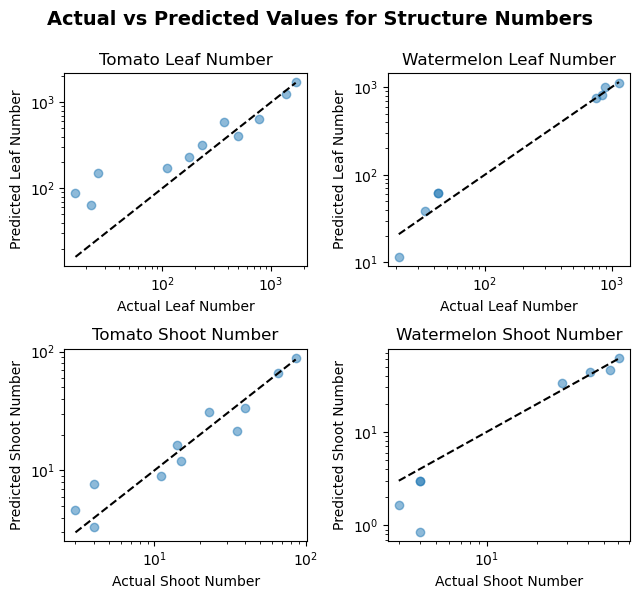

In [35]:
# Plot actual vs predicted values for each species and parameter not using seaborn
fig, axs = plt.subplots(2, 2, figsize=(6.5, 6))
fig.suptitle('Actual vs Predicted Values for Structure Numbers', fontsize=14, fontweight='bold', y=0.99)
# Tomato Leaf Number
axs[0, 0].set_title('Tomato Leaf Number')
axs[0, 0].scatter(tln['true_value'], tln['predicted_value'], alpha=0.5, label='Tomato Leaf Number')
axs[0, 0].plot([tln['true_value'].min(), tln['true_value'].max()], 
				[tln['true_value'].min(), tln['true_value'].max()], 
				color='black', linestyle='--', label='Perfect Prediction')
axs[0, 0].set_xlabel('Actual Leaf Number')
axs[0, 0].set_ylabel('Predicted Leaf Number')
axs[0, 0].set_xscale('log')
axs[0, 0].set_yscale('log')
# Tomato Shoot Number
axs[1, 0].set_title('Tomato Shoot Number')
axs[1, 0].scatter(tsn['true_value'], tsn['predicted_value'], alpha=0.5, label='Tomato Shoot Number')
axs[1, 0].plot([tsn['true_value'].min(), tsn['true_value'].max()], 
				[tsn['true_value'].min(), tsn['true_value'].max()], 
				color='black', linestyle='--', label='Perfect Prediction')
axs[1, 0].set_xlabel('Actual Shoot Number')
axs[1, 0].set_ylabel('Predicted Shoot Number')
axs[1, 0].set_xscale('log')
axs[1, 0].set_yscale('log')
# Watermelon Leaf Number
axs[0, 1].set_title('Watermelon Leaf Number')
axs[0, 1].scatter(wln['true_value'], wln['predicted_value'], alpha=0.5, label='Watermelon Leaf Number')
axs[0, 1].plot([wln['true_value'].min(), wln['true_value'].max()], 
				[wln['true_value'].min(), wln['true_value'].max()], 
				color='black', linestyle='--', label='Perfect Prediction')
axs[0, 1].set_xlabel('Actual Leaf Number')
axs[0, 1].set_ylabel('Predicted Leaf Number')
axs[0, 1].set_xscale('log')
axs[0, 1].set_yscale('log')
# Watermelon Shoot Number
axs[1, 1].set_title('Watermelon Shoot Number')
axs[1, 1].scatter(wsn['true_value'], wsn['predicted_value'], alpha=0.5, label='Watermelon Shoot Number')
axs[1, 1].plot([wsn['true_value'].min(), wsn['true_value'].max()], 
				[wsn['true_value'].min(), wsn['true_value'].max()], 
				color='black', linestyle='--', label='Perfect Prediction')
axs[1, 1].set_xlabel('Actual Shoot Number')
axs[1, 1].set_ylabel('Predicted Shoot Number')
axs[1, 1].set_xscale('log')
axs[1, 1].set_yscale('log')
# Adjust layout
plt.tight_layout()